In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import PorterStemmer
import contractions

ps = PorterStemmer()

from nltk.tokenize.sonority_sequencing import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopword = stopwords.words('english')
import string
punct = string.punctuation
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

# Initialize wordnet lemmatizer
wnl = WordNetLemmatizer()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional


[nltk_data] Downloading package stopwords to /home/vedant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vedant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vedant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vedant/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2023-07-13 10:07:48.809689: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-13 10:07:48.846575: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 10:07:49.092129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not fin

In [3]:
!pip install contractions

Defaulting to user installation because normal site-packages is not writeable


In [46]:
train_df = pd.read_csv("train.txt",delimiter = ";", names = ["text", "label"])
train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [47]:
val_df = pd.read_csv("val.txt", delimiter = ";", names = ["text", "label"])
val_df.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [48]:
train_df.label.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

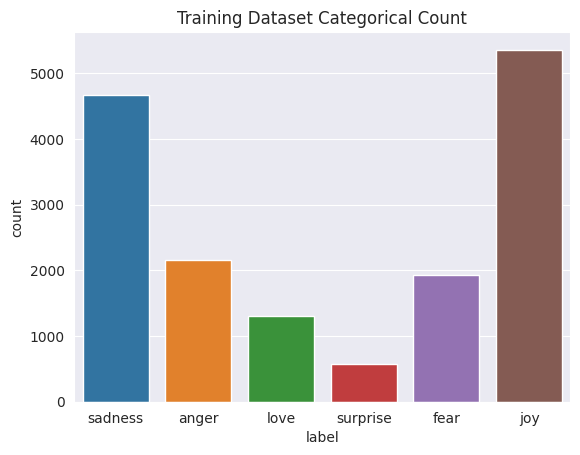

In [49]:
sns.set_style("darkgrid")
sns.countplot(data=train_df, x = "label")
plt.title("Training Dataset Categorical Count")
plt.show()

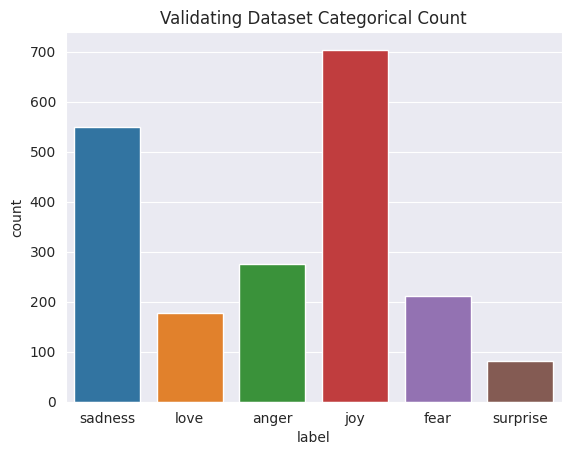

In [50]:
sns.set_style("darkgrid")
sns.countplot(data=val_df, x = "label")
plt.title("Validating Dataset Categorical Count")
plt.show()

In [51]:
def Cleaning_text(text):
  text = contractions.fix(text)
  token=nltk.word_tokenize(text)
  token=[wnl.lemmatize(x.lower()) for x in token if x not in stopword and x not in punct]
  text=" ".join(token)
  return text

In [52]:
train_df.text = train_df.text.apply(Cleaning_text)
train_df.text[0]

'feel humiliated'

In [53]:
from wordcloud import WordCloud, STOPWORDS

In [60]:
def wordcloud_fig(df):
  fig, ax = plt.subplots(nrows = 6, ncols = 1,figsize=(6,30))
  cols = ["sadness","anger","love","surprise","fear","joy"]
  for i in range(len(cols)):
    data1 = df.loc[df["label"] == cols[i], "text" ].tolist()
    data = " ".join(data1)
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(data)
    ax[i].imshow(wordcloud)
    ax[i].set_title(cols[i])
    ax[i].axis("off")
  plt.tight_layout()
  plt.show()

  return

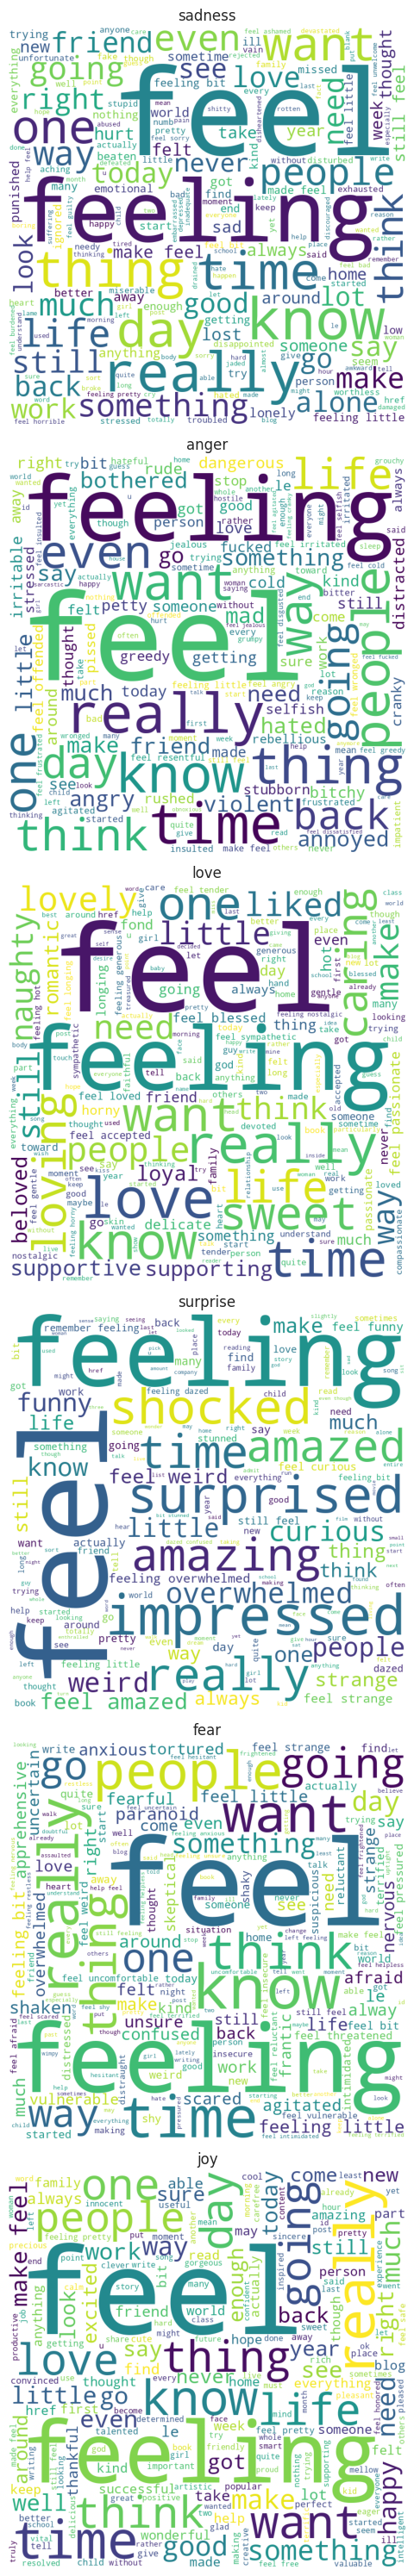

In [61]:
wordcloud_fig(train_df)

In [7]:
val_df.text = val_df.text.apply(Cleaning_text)
val_df.text[0]

'feeling quite sad sorry ill snap soon'

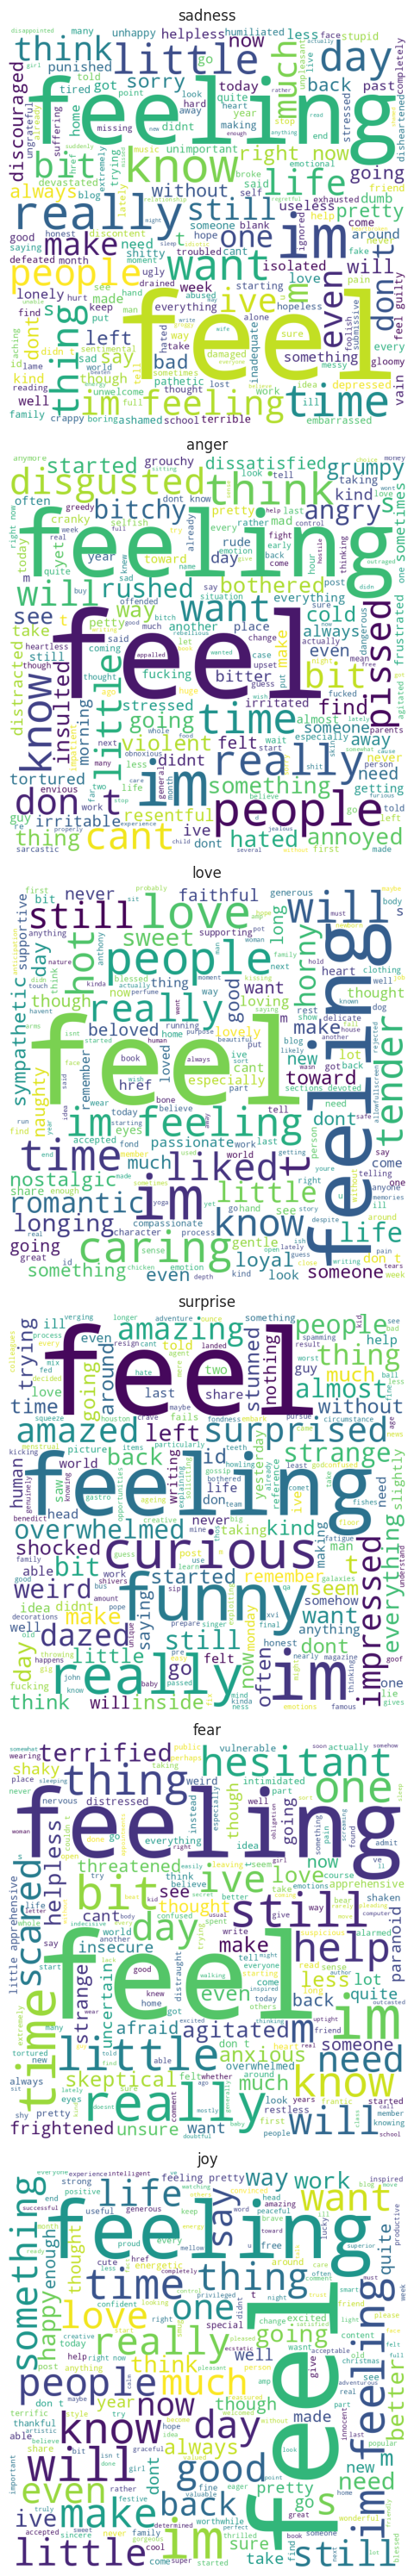

In [62]:
wordcloud_fig(val_df)

In [12]:
def train_model(model, data, target):
    
    pipe = Pipeline(steps=[("tfidf_vec", TfidfVectorizer()),("model", model)])
    pipe.fit(data, target)
    return pipe 

In [11]:
rf = train_model(RandomForestClassifier(), train_df.text, train_df.label)
prediction = rf.predict(val_df.text)
accuracy_score(val_df.label, prediction)

0.894

In [12]:
model = AdaBoostClassifier(estimator=RandomForestClassifier(), n_estimators = 5)
abc = train_model(model, train_df.text, train_df.label)
prediction = abc.predict(val_df.text)
accuracy_score(val_df.label, prediction)

0.781

In [13]:
model = AdaBoostClassifier(estimator=RandomForestClassifier(),n_estimators=2)
abc = train_model(model, train_df.text, train_df.label)
prediction = abc.predict(val_df.text)
accuracy_score(val_df.label, prediction)

0.875

In [14]:
lgb = LGBMClassifier(learning_rate=0.09,max_depth=17,random_state=42)

In [15]:
lgb_model = train_model(lgb, train_df.text, train_df.label)
prediction = lgb_model.predict(val_df.text)
accuracy_score(val_df.label, prediction)

0.883

In [8]:
le = LabelEncoder()
train_df.label = le.fit_transform(train_df.label)
val_df.label = le.transform(val_df.label)

In [30]:
train_df.label[0]

4

In [9]:
def to_category(data):
    n = data.label.nunique()
    category = to_categorical(data.label, num_classes = n)
    return category

In [10]:
train_category = to_category(train_df)

In [19]:
train_category

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [11]:
val_category = to_category(val_df)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.text)


In [13]:
with open('my_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [14]:
train_data = tokenizer.texts_to_sequences(train_df.text)
val_data = tokenizer.texts_to_sequences(val_df.text)
train_data[0]

[1, 548]

In [15]:
maxx = 0
for i in train_data + val_data:
    maxx = max(len(i),maxx)
maxx

35

In [16]:
import keras

In [18]:

vocab_size = len(tokenizer.word_counts) + 1  # Total number of unique words in the vocabulary
embedding_dim = 100  # Dimensionality of the embedding space


# Pad sequences
maxx = 35
padded_train_data = pad_sequences(train_data, maxlen=maxx)
padded_val_data = pad_sequences(val_data, maxlen=maxx)

# Reshape the input data to add a third dimension
padded_train_data = np.expand_dims(padded_train_data, axis=2)
padded_val_data = np.expand_dims(padded_val_data, axis=2)

# Convert input data to float32
padded_train_data = padded_train_data.astype(np.float32)
padded_val_data = padded_val_data.astype(np.float32)

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=maxx))
model1.add(Bidirectional(LSTM(64, dropout=0.4,)))
# model1.add(Bidirectional(LSTM(36, dropout=0.3)))
regularise = keras.regularizers.l1(0.035)
model1.add(Dense(6, activation="softmax",kernel_regularizer=regularise))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.008), metrics=['accuracy'])

# Train the model
model1.fit(x=padded_train_data, y=train_category, batch_size=500, epochs=30, validation_data=(padded_val_data, val_category))



Epoch 1/30
32/32 [==============================] - 5s 97ms/step - loss: 2.5294 - accuracy: 0.4618 - val_loss: 1.5594 - val_accuracy: 0.6020
Epoch 2/30
32/32 [==============================] - 3s 83ms/step - loss: 1.2523 - accuracy: 0.6681 - val_loss: 1.0753 - val_accuracy: 0.7210
Epoch 3/30
32/32 [==============================] - 3s 86ms/step - loss: 0.9837 - accuracy: 0.7301 - val_loss: 1.0111 - val_accuracy: 0.7255
Epoch 4/30
32/32 [==============================] - 3s 84ms/step - loss: 0.9002 - accuracy: 0.7440 - val_loss: 0.9512 - val_accuracy: 0.7365
Epoch 5/30
32/32 [==============================] - 3s 85ms/step - loss: 0.8650 - accuracy: 0.7479 - val_loss: 0.9454 - val_accuracy: 0.7305
Epoch 6/30
32/32 [==============================] - 3s 96ms/step - loss: 0.8498 - accuracy: 0.7494 - val_loss: 0.9289 - val_accuracy: 0.7355
Epoch 7/30
32/32 [==============================] - 5s 146ms/step - loss: 0.8262 - accuracy: 0.7610 - val_loss: 0.9142 - val_accuracy: 0.7480
Epoch 8/30
3

In [20]:
df = pd.DataFrame(model1.history.history)

In [21]:
df.head(1)

,loss,accuracy,val_loss,val_accuracy
0,2.529367,0.46175,1.55939,0.602


<AxesSubplot: >

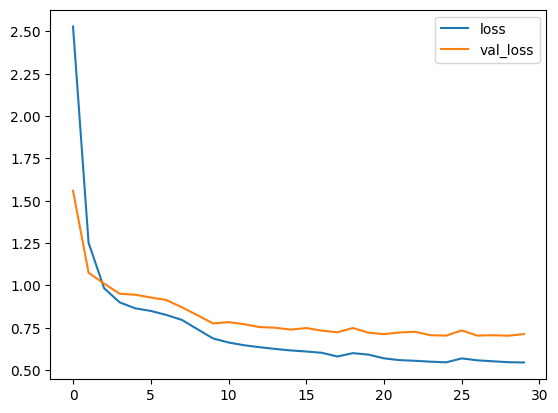

In [22]:
df[["loss", "val_loss"]].plot()

<AxesSubplot: >

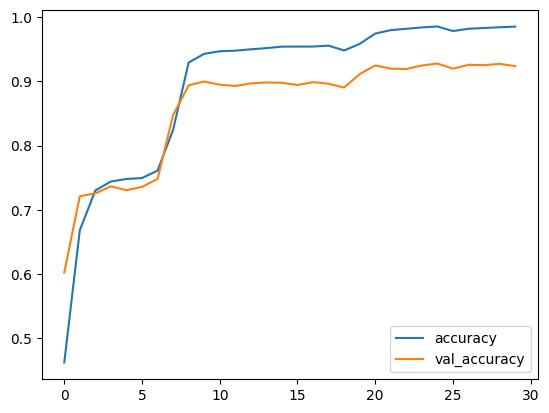

In [23]:
df[["accuracy", "val_accuracy"]].plot()

In [28]:
# model1.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [24]:
val_category[:1]

array([[0., 0., 0., 0., 1., 0.]], dtype=float32)

In [38]:
le.inverse_transform([np.argmax(model1.predict(padded_val_data[:1]))])

1/1 [==============================] - 0s 12ms/step


array(['sadness'], dtype=object)

In [40]:
le.inverse_transform([np.argmax(val_category[:1])])

array(['sadness'], dtype=object)

In [41]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le,f)